In [ ]:
#Download the data
!wget https://biodynamics.ucsd.edu/wp-content/uploads/2020/08/features_targets_loadingrecord.zip
#Create a new folder for the data
!mkdir data_chem
#Unzip the data
!unzip features_targets_loadingrecord -d data_chem/
!rm features_targets_loadingrecord.zip
!echo "data_chem/" >> .gitignore

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy as sp
from scipy.signal import savgol_filter as savgol 
from copy import deepcopy    
from random import choices
from scipy.stats import ttest_ind
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib import cm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF','#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
npg_color_list = []
for this_color in npg_colors: 
    npg_color_list.append(list(int(this_color[1:][i:i+2], 16)/255 for i in (0, 2, 4)))
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
plt.rcParams.update({'font.size':25});
plt.rcParams.update({'axes.linewidth':1.5})
plt.rc('lines',linewidth=3);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
ncolors = 10
plt.rc('axes', axisbelow=True)

from preprocess import *
from dmd import *
from sensor_placement import *
# from query_uniprot import *
from regions import *
from plot_ellipsoid import *

## Data loading

This section downloads the data prepares it for the data-preprocessing step. The last step before preprocessing combines duplicated genes by taking their average.

In [2]:
#Load the matrix with all the data
data_full = pd.read_csv("./data_chem/features.csv")
#Load induction time profiles
u_ts = pd.read_csv("./data_chem/targets.csv")
#Load genes
genes = pd.read_csv("./data_chem/loading_record.csv")

In [3]:
#List and print all experiments
exp_id = data_full.exp_id.unique()
# print(exp_id)

#Select the experiment
exp_of_interest = 1 #this selects the first experiment only

#Subselecting data for the experiment of interest
df_exp = data_full[data_full.exp_id == exp_id[exp_of_interest-1]].drop(columns=["Unnamed: 1", "exp_id"])

#Renaming columns
df_exp.columns = genes.gene_name

#Filtering out spots with no strain averaging duplicate genes
df_exp=df_exp.iloc[:,df_exp.columns.notna()]

In [4]:
# This section extracts the input profile
# Display the unique values in the "induction_state" column
u_ts = deepcopy(u_ts[u_ts.exp_id == exp_id[exp_of_interest-1]])

unique_induction_states = u_ts["induction_state"].unique()

# Define a mapping for encoding of u_ts
encoding_map = {
    "('MilliQ_ddH2O',)": 0,
}

# Assign subsequent integers to other unique values
for idx, state in enumerate(unique_induction_states, start=0):
    if state not in encoding_map:
        encoding_map[state] = idx

u_ts["induction_state_encoded"] = u_ts["induction_state"].map(encoding_map)


# Create a dictionary to store start and end indices for each induction state occurrence
induction_intervals = {}

# Initialize variables to keep track of the current state and its start index
current_state = None
start_index = None

# Loop through rows in the DataFrame
for idx, row in u_ts.iterrows():
    state = row["induction_state"]
    
    # If we encounter a new state or reach the end of the DataFrame
    if current_state != state or idx == u_ts.index[-1]:
        # If we were tracking a state, save its interval (except for the first iteration)
        if current_state is not None:
            # Adjust end index for the last entry in the DataFrame
            end_index = idx if idx == u_ts.index[-1] and current_state == state else idx - 1
            if current_state in induction_intervals:
                induction_intervals[current_state].append((start_index, end_index))
            else:
                induction_intervals[current_state] = [(start_index, end_index)]
        
        # Start tracking the new state
        current_state = state
        start_index = idx

induction_intervals

{"('MilliQ_ddH2O',)": [(0, 107), (132, 371), (396, 638), (664, 789)],
 "('Cd(II)',)": [(108, 131), (639, 663)],
 "('Pb(II)',)": [(372, 395)]}

In [5]:
# stimulus_of_interest = 1 #This is selecting the first "kick" only

# # This block identified start and end time of each stimulus (i.e. whenever the same stimulus has been applied > 1x in an experiment it allows to subselect "duplicates")

# start_time = [i[0] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
# end_time = [i[1] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]

# df_exp = deepcopy(df_exp.iloc[start_time[0]:end_time[0]+1,:])
# df_exp.shape

In [6]:
#In the original dataset there are several "biological replicates", i.e. spots of the chip where the same gene is tracked
#This snippet of code averages all these spots to obtain a final dataset with one column per gene
duplicated_columns = df_exp.columns[df_exp.columns.duplicated(keep=False)].unique()

for i in duplicated_columns:
    print("The gene ",i, " has ", df_exp[i].shape[1], " spots associated to it (biological replicates)")

# Create a new DataFrame to store the results
df_result = pd.DataFrame()

# Process non-duplicated columns
for column in df_exp.columns:
    if column not in duplicated_columns:
        df_result[column] = df_exp[column]

# Process duplicated columns
for dup_col in duplicated_columns:
    # Take the average of duplicated columns and assign to the result DataFrame
    df_result[dup_col] = df_exp[dup_col].mean(axis=1)

df_result.head()

The gene  zntA  has  15  spots associated to it (biological replicates)
The gene  rpoS  has  15  spots associated to it (biological replicates)
The gene  cueO  has  15  spots associated to it (biological replicates)
The gene  rpoH  has  15  spots associated to it (biological replicates)
The gene  wrbA  has  21  spots associated to it (biological replicates)
The gene  rpoD  has  15  spots associated to it (biological replicates)
The gene  fimD  has  15  spots associated to it (biological replicates)
The gene  lacZ  has  22  spots associated to it (biological replicates)
The gene  yacH  has  2  spots associated to it (biological replicates)
The gene  U66  has  20  spots associated to it (biological replicates)
The gene  serA  has  21  spots associated to it (biological replicates)
The gene  U139  has  20  spots associated to it (biological replicates)
The gene  tdcG_2  has  2  spots associated to it (biological replicates)
The gene  infA  has  3  spots associated to it (biological replic

/tmp/ipykernel_79935/3742261841.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[column] = df_exp[column]
/tmp/ipykernel_79935/3742261841.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[dup_col] = df_exp[dup_col].mean(axis=1)


,rihC,ypfH,alsI,ygdQ,yabP,ypfJ,talB,yqeI,yabI,hda,...,rpoD,fimD,lacZ,yacH,U66,serA,U139,tdcG_2,infA,yebF
0,-0.022629,0.148508,-0.088955,-0.232066,0.069350,-0.644056,-0.030329,-0.020271,0.158288,1.246769,...,-0.084612,-0.012124,-0.064123,-0.065857,-0.063226,2.938553,-0.079553,-0.094431,-3.164757,-0.242952
1,-0.075618,-0.191642,-0.041127,0.221798,0.114038,-0.554063,-0.029043,0.117677,0.020580,1.160078,...,-0.051237,-0.009570,-0.067436,-0.047152,-0.096200,3.144924,-0.022218,-0.034728,-1.831284,0.094008
2,0.053473,0.146480,-0.111173,0.138315,0.002590,-0.147216,-0.113246,-0.030373,0.089998,1.312099,...,-0.020321,-0.031348,-0.067067,0.027820,-0.080628,3.385740,-0.017088,-0.034646,-3.035438,-0.126263
3,-0.137537,-0.224630,-0.055299,0.019529,0.085433,-0.508369,0.011168,-0.104683,0.235458,0.657336,...,-0.018129,-0.012545,-0.007957,-0.086683,-0.067020,2.658177,-0.048128,-0.101937,-2.332679,0.168084
4,-0.001089,0.149665,0.019627,0.292656,-0.153317,-0.116954,-0.076620,-0.048036,0.044441,1.461989,...,-0.072185,-0.016076,-0.097118,-0.055341,-0.110282,2.639522,-0.048160,-0.161916,-1.510021,0.566953


In [7]:
# #Saving THE experiment selected to a csv file
df_result.to_csv("./data_chem/exp"+str(exp_id[exp_of_interest-1])+".csv", index=False)

## Data pre-processing

In this section we do 2 things:
1. Use a smoothing filter to smoothen the data
2. Renormalise all time series so that each gene has $\mu = 0$ and $\sigma = 1$

In [8]:
df = deepcopy(df_result) #renaming the array for simplicity (and because I'm lazy :P)

print("There are "+str(len(induction_intervals))+" in this experiment.")
for i,x in enumerate(induction_intervals):
    print(i,". ",x)
stimulus_of_interest=int(input("Which input are you interested in?"))-1

start_time = [i[0] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
end_time = [i[1] for i in induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]]]
replicates = len(induction_intervals[u_ts.induction_state.unique()[stimulus_of_interest]])

input_label = u_ts.induction_state.unique()[stimulus_of_interest][2:-3]

print("\n You selected: "+u_ts.induction_state.unique()[stimulus_of_interest])

There are 3 in this experiment.
0 .  ('MilliQ_ddH2O',)
1 .  ('Cd(II)',)
2 .  ('Pb(II)',)

 You selected: ('Cd(II)',)


In [9]:
#This the maximum length of the time-series (i.e. the number of rows) in the 3D matrix, given that  
max_w = np.min([(end_time[i] - start_time[i]) for i in range(len(start_time))])

#Creating the 3D matrix
data = np.empty(shape=(max_w+1, len(df.columns), replicates))

In [10]:
#Assembling the 3D array, based on the stimulus selected (note that the 3rd dimension might be a singleton)
for  i in range(replicates):
    # print(i+1)
    data[:,:,i] = df.iloc[start_time[i]:start_time[i]+max_w+1,:].values
    # print(start_time[i], start_time[i]+max_w)

In [11]:
#This section simply filters the data (row-wise, as each row now it's a gene)
from scipy.signal import savgol_filter as savgol 

data = data.transpose(1,0,2)
data_f = savgol(data, window_length=5, polyorder=2, axis=1)

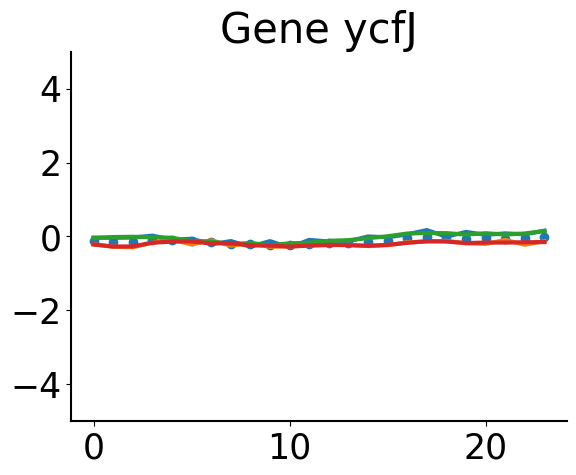

In [12]:
#Take a look at the effect of the Savitzky-Golay (5,2) filter
rnd_gene = np.random.randint(data.shape[0])

plt.plot(data[rnd_gene, :, :])
plt.plot(data_f[rnd_gene, :, :])
plt.scatter(range(24), np.mean(data_f[rnd_gene, :, :], axis=1))
plt.ylim([-5,5])
plt.title("Gene "+df.columns[rnd_gene] )
plt.show()

In [13]:
from preprocess import standardize_time_series

data_fs = standardize_time_series(data_f, data_f.shape[1], data_f.shape[2])


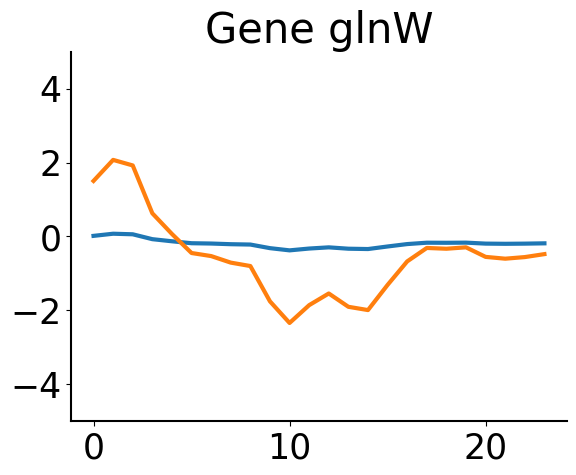

In [14]:
#Take a look at the effect of the Standardiser
rnd_gene = np.random.randint(data.shape[0])

plt.plot(data_f[rnd_gene, :, 0])
plt.plot(data_fs[rnd_gene, :, 0])
plt.ylim([-5,5])
plt.title("Gene "+df.columns[rnd_gene] )
plt.show()

In [15]:
from dmd import *

r = 10
A,Atilde,data_fc_norm_red,U_r,cd,eVals_r,eVecs_r,Phi,b_r0,b_r1 = \
        dmd(data_fs,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3) #trimThesh=2.5e-3

r2_score for n-step prediction (reduced): 8.632e-01


In [16]:
#In this section we compute the Gram matrix of the system
from sensor_placement import gram_matrix

nT = data_fs.shape[1]

G = gram_matrix(A, data_fs[:,0,:], nT = nT, reduced = False)

In [17]:
Gt, Gt_recon = gram_matrix(Atilde,data_fc_norm_red[:,0,:],nT=100,reduced=True,projection_matrix=U_r)

In [18]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
import scipy as sp

D, V = sp.linalg.eig(G,left=False,right=True)
Dt,Vt = sp.linalg.eig(Gt,left=False,right=True)
Dt_recon, Vt_recon = sp.linalg.eig(Gt_recon,left=False,right=True)

In [19]:
# get gene sampling weights
# W = Vt_recon[:,0:p].T
W = V[:,0:1].T
# W = V[:,1:2].T
sorted_inds = list(np.argsort(np.abs(W[0,:]))) # based on top eigenvector only
sorted_tags = [df.columns[x] for x in sorted_inds]
Wsorted = deepcopy(W)[:,sorted_inds] # Used to generate percent rank of genes

# normalize gene sampling weights
gene_std = np.mean(np.std(data_fs,axis=2),axis=1)
Wn = W[0]/( gene_std )
sorted_inds_n = list(np.argsort(np.abs(Wn))) 
sorted_tags_n = [df.columns[x] for x in sorted_inds_n]
Wsorted_n = deepcopy(Wn)[sorted_inds_n]

# apply shrinkage to standard deviations based on sampling weights, then normalize
z, cov = np.polyfit(x=W[0], y=gene_std, deg=2, cov=True)
x_w = np.linspace(W[0].min(),W[0].max(),len(W[0]))
std_x_w = z[0]*x_w**2+z[1]*x_w+z[2]
Ws = W[0] / std_x_w # normalized via shrinkage estimated std
sorted_inds_s = list(np.argsort(np.abs(Ws))) 
sorted_tags_s = [df.columns[x] for x in sorted_inds_s]

Wsorted_s = deepcopy(Ws)[sorted_inds_s]

In [20]:
# takes several minutes to run
from sensor_placement import reconstruct_x0_sequential
import pickle

data_fc_norm = data_fs
samplingFreq = 30

doRun = False
if doRun:
    rho_T10 = reconstruct_x0_sequential(data_fc_norm,10,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top') # second argument is number of timepoints
    rho_T9 = reconstruct_x0_sequential(data_fc_norm,9,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T8 = reconstruct_x0_sequential(data_fc_norm,8,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T7 = reconstruct_x0_sequential(data_fc_norm,7,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T6 = reconstruct_x0_sequential(data_fc_norm,6,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T5 = reconstruct_x0_sequential(data_fc_norm,5,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T4 = reconstruct_x0_sequential(data_fc_norm,4,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T3 = reconstruct_x0_sequential(data_fc_norm,3,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T2 = reconstruct_x0_sequential(data_fc_norm,2,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T1 = reconstruct_x0_sequential(data_fc_norm,1,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_list = [rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1]
    
doRunRand = False
if doRunRand: 
    rho_T10_rand = reconstruct_x0_sequential(data_fc_norm,10,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T9_rand = reconstruct_x0_sequential(data_fc_norm,9,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T8_rand = reconstruct_x0_sequential(data_fc_norm,8,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T7_rand = reconstruct_x0_sequential(data_fc_norm,7,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T6_rand = reconstruct_x0_sequential(data_fc_norm,6,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T5_rand = reconstruct_x0_sequential(data_fc_norm,5,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T4_rand = reconstruct_x0_sequential(data_fc_norm,4,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T3_rand = reconstruct_x0_sequential(data_fc_norm,3,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T2_rand = reconstruct_x0_sequential(data_fc_norm,2,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T1_rand = reconstruct_x0_sequential(data_fc_norm,1,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')

doSave = False
if doSave: 
    pickle.dump([rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1],open('data/reconstructions.pkl','wb'))
#     pickle.dump([rho_T10_rand,rho_T9_rand,rho_T8_rand,rho_T7_rand,rho_T6_rand,rho_T5_rand,rho_T4_rand,rho_T3_rand,rho_T2_rand,rho_T1_rand],open('data/reconstructions_random.pkl','wb'))

if not doRun:
    rho_list = pickle.load(open('data/reconstructions.pkl','rb'))
if not doRunRand:
    rho_rand_list = pickle.load(open('data/reconstructions_random.pkl','rb'))

In [21]:
#This block selects the top 15 genes (last in the sorted_tags_s vector), i.e. the "heaviest" by observability

# # If you want to select a random set of the top (say in the up third), review this code

# # np.random.randint(int(len(sorted_tags)*2/3), len(sorted_tags), size=15, repl)
# # plt.hist(len(sorted_tags)-np.random.exponential(scale=10, size=15))
# # plt.show()
# ii = np.zeros(1807)  
# np.random.seed(1000)
# ttags = np.abs(len(sorted_tags)-np.random.exponential(scale=300, size=15)).round().astype(int)

# ii[ttags]=1

# plt.plot(ii.cumsum())
# plt.xlim()
# plt.show()


gene = sorted_tags_s[-15:]
locus_tags = ['PFLU_'+str(np.random.randint(1000, 9999)) for i in range(10,25)]
tag_inds = sorted_inds_s[-15:]

df_up_new = pd.DataFrame({'gene': gene, 'locus_tags':locus_tags, 'tag_ind': tag_inds})

In [22]:
rank_tag_inds = []
for ii in tag_inds:
    rank_tag_inds.append(len(W[0]) - list(Wsorted[0]).index(W[0][ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(W[0]) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_rank'] = rank_tag_inds_per

rank_tag_inds = []
for ii in tag_inds:
    rank_tag_inds.append(len(Wn) - list(Wsorted_n).index(Wn[ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(Wn) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_stand_rank'] = rank_tag_inds_per

rank_tag_inds  = []
for ii in tag_inds:
    rank_tag_inds.append(len(Ws) - list(Wsorted_s).index(Ws[ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(Ws) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_stand_shrink_rank'] = rank_tag_inds_per

df_up_new

,gene,locus_tags,tag_ind,obs_rank,obs_stand_rank,obs_stand_shrink_rank
0,lacZ,PFLU_4801,1799,92.81,85.67,99.23
1,borD,PFLU_5318,1743,97.79,97.29,99.28
2,tdcG_2,PFLU_9737,1804,92.47,84.56,99.34
3,yfcC,PFLU_6685,1720,99.17,98.06,99.39
4,rihC,PFLU_4971,0,91.59,90.43,99.45
5,b0663,PFLU_7700,1776,96.35,96.51,99.50
6,xasA,PFLU_8516,99,99.39,99.94,99.56
7,zntA,PFLU_4721,1792,95.07,93.69,99.61
8,yidR,PFLU_7682,71,99.00,96.90,99.67
9,fimD,PFLU_9406,1798,96.57,92.53,99.72


In [23]:
figDir = './data_chem/figures'
corr_tspan = list(range(10,250,10))# for xaxis in many figures

In [24]:
import matplotlib

mode pairs:  [[0, 1], [2, 3], [4], [5, 6], [7, 8], [9]]


/tmp/ipykernel_79935/4069500019.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


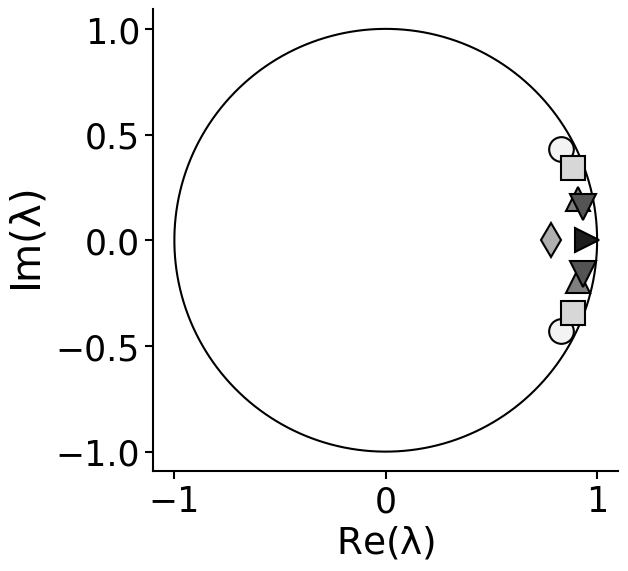

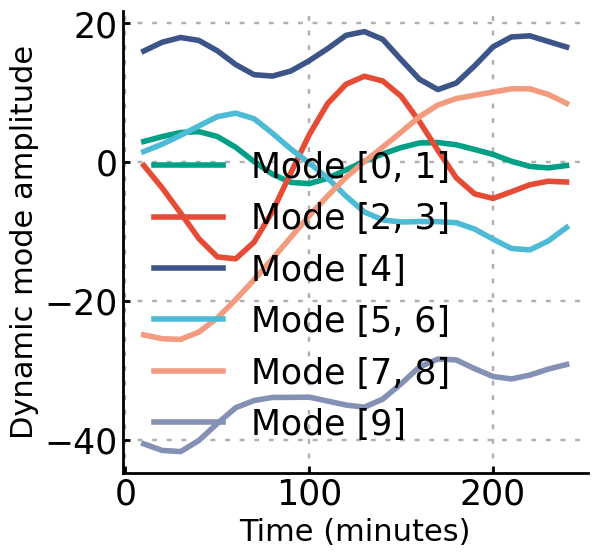

In [25]:
# plot the eigenvalues on the unit circle

savefig = False
# automate mode pairing (data is real-valued, complex eigs comes with a conjugate pair -- no need to plot both)
mode_pairs = []
cnt = 0
while cnt in range(len(eVals_r)): 
    if cnt+1 != len(eVals_r): # have we reached the boundary?
        if np.abs(eVals_r[cnt]) == np.abs(eVals_r[cnt+1]): # if no, then check if the two are c.c. pairs
            mode_pairs.append([cnt,cnt+1])
            cnt += 2
        else: # if no, and not c.c. pairs
            mode_pairs.append([cnt])
            cnt += 1
    else: # if boundary
        mode_pairs.append([cnt])
        cnt += 1
print('mode pairs: ', mode_pairs)

# size the eigenvalue marker by corresponding mode power ||Phi_i||
mode_powers = np.linalg.norm(Phi,axis=0)
my_ms = [9*2**n for n in mode_powers] # the 9*2**n is an arbitrary scaling for marker size

fig1,ax1 = plt.subplots(1,1,figsize=(6,6))
fig2,ax2 = plt.subplots(1,1,figsize=(6,6))
theta = np.linspace(0,2*np.pi,200)
ax1.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)

markers = ['o','s','d','^','v','>']
cmap = matplotlib.cm.get_cmap('Greys')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.1,0.9,6)]
for ii in range(len(mode_pairs)):
    scaled_mode = np.real(eVals_r[ii]*b_r1[mode_pairs[ii][0]])

    ax2.plot(corr_tspan,savgol(scaled_mode,3,1),'-',c=npg_colors[ii],lw=4,label='Mode ' + str(mode_pairs[ii]))
#     ax1.plot(np.real(eVals_r[mode_pairs[ii][0]]),np.imag(eVals_r[mode_pairs[ii][0]]),
#                 marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)
#     if len(mode_pairs[ii]) == 2: 
#         ax1.plot(np.real(eVals_r[mode_pairs[ii][1]]),np.imag(eVals_r[mode_pairs[ii][1]]),
#                 marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)
    ax1.plot(np.real(eVals_r[mode_pairs[ii][0]]),np.imag(eVals_r[mode_pairs[ii][0]]),
                marker=markers[ii],mfc=grad_colors[ii],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=1.5)
    if len(mode_pairs[ii]) == 2: 
        ax1.plot(np.real(eVals_r[mode_pairs[ii][1]]),np.imag(eVals_r[mode_pairs[ii][1]]),
                marker=markers[ii],mfc=grad_colors[ii],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=1.5)

ax1.axis('equal')
ax1.set_xlabel(r'$\mathregular{Re(\lambda)}$',fontsize=27)
ax1.set_ylabel(r'$\mathregular{Im(\lambda)}$',fontsize=29)
ax1.set_ylim(-1,1)
ax1.set_yticks(np.arange(-1,1.5,0.5))
ax1.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax1.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')

ax2.set_xlabel('Time (minutes)',fontsize=22)
ax2.set_ylabel('Dynamic mode amplitude',fontsize=22)
ax2.legend(frameon=False,ncol=1)
ax2.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax2.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')

for side in ax1.spines.keys():
    ax2.spines[side].set_linewidth(2)

ax2.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
    
if savefig: 
    fig1.savefig(figDir + 'fig2/eigvals.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

r2_score for n-step prediction (reduced): 8.112e-01
r2_score for n-step prediction (reduced): 8.672e-01
r2_score for n-step prediction (reduced): 8.632e-01
r2_score for n-step prediction (reduced): 8.312e-01
r2_score for n-step prediction (reduced): 8.945e-01
r2_score for n-step prediction (reduced): 8.861e-01


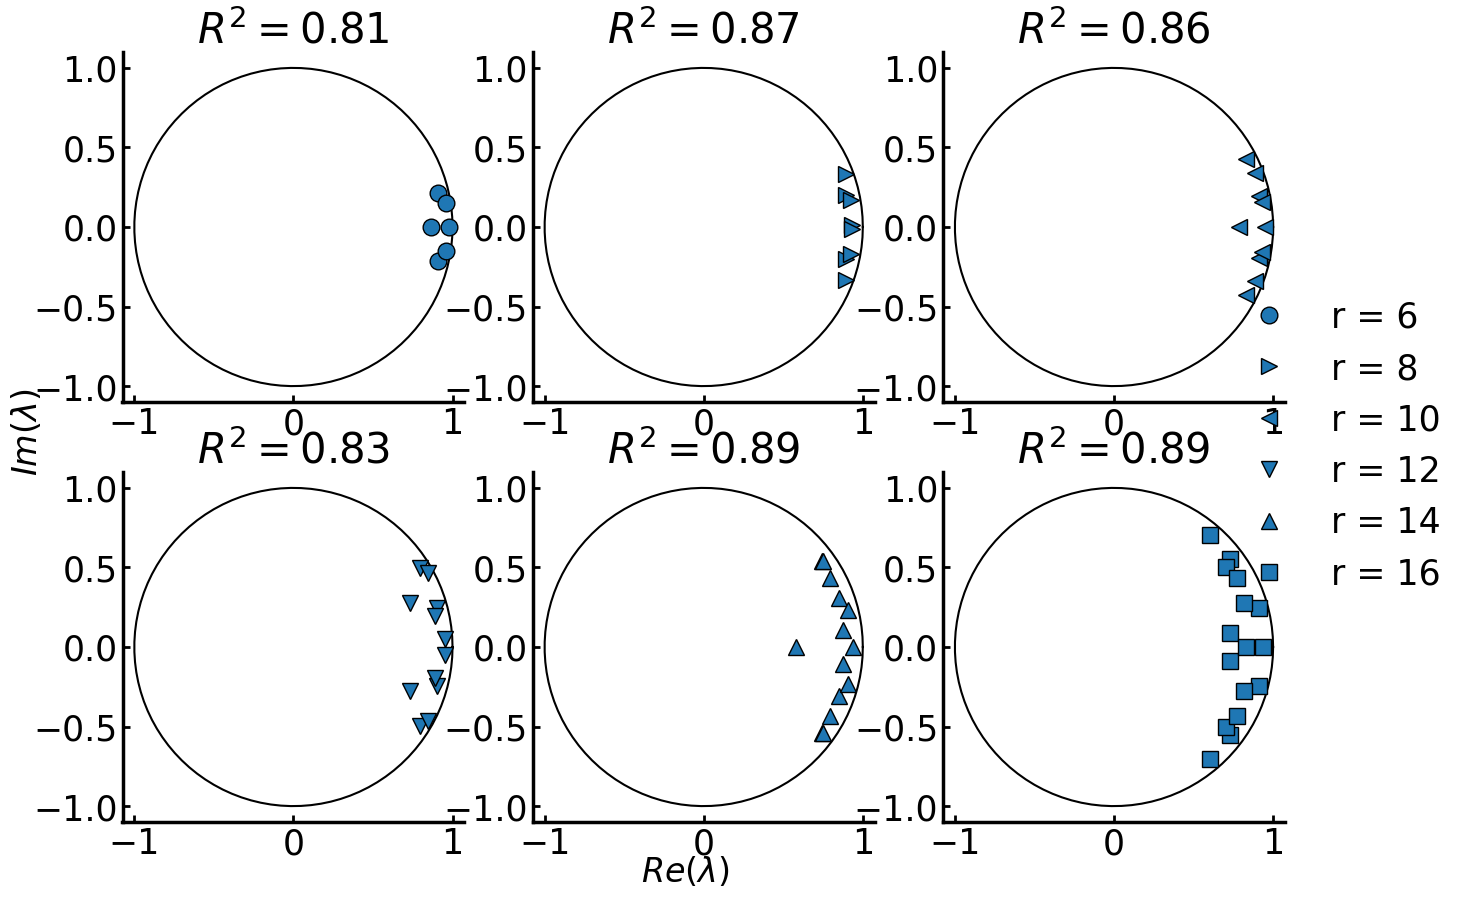

In [26]:
# make a plot that shows magnitude of eigvals for varying r
# supplemental figure

savefig = False

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

r_list = [6,8,10,12,14,16]
evals_list,cd_list = [],[]
for rr in r_list: 
    _,_,_,_,cdr,evals,_,_,_,_ = \
                            dmd(data_fc_norm,rank_reduce=True,r=rr,trim=True,trimThresh=2e-3)
    evals_list.append(evals)
    cd_list.append(cdr)

# fig,ax = plt.subplots(1,1,figsize=(7,7))
# my_ms = ['>','o','<','v','^']
# for ii,evals in enumerate(evals_list):
#     ax.plot(np.sort(np.abs(evals))[::-1],my_ms[ii],mec='k',c=npg_colors[ii],mew=1,ms=12
#             ,label='r = '+str(r_list[ii]))
# for side in ax.spines.keys():
#     ax.spines[side].set_linewidth(2.5)
# ax.set_ylabel(r'$|\mathregular{\lambda}|$',fontsize=26)
# ax.set_xticks(range(0,20,5))
# ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
# ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
# ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
# fig.legend(frameon=False,bbox_to_anchor=(1,0.9))
# if savefig: 
#     plt.savefig(figDir + 'fig2/magEvals_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
# plt.show()

fig,axs = plt.subplots(2,3,figsize=(15,10))
theta = np.linspace(0,2*np.pi,100)
my_ms = ['o','>','<','v','^','s']
for ii,ax in enumerate(axs.reshape(-1)):
    ax.plot(np.cos(theta),np.sin(theta),c='k',lw=1.5)
    ax.plot(np.real(evals_list[ii]),np.imag(evals_list[ii]),my_ms[ii],ms=12,label='r = '+str(r_list[ii]),
            c='tab:blue',mec='k')
    ax.set_title(r'$R^2=$' + str(np.round(cd_list[ii],2)))
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.axis('equal')
#         ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
fig.legend(frameon=False,bbox_to_anchor=(1.025,0.663))
fig.text(0.5, 0.05, r'$Re(\lambda)$', ha='center',fontsize=24);
fig.text(0.05, 0.5, r'$Im(\lambda)$', va='center', rotation='vertical',fontsize=24);
if savefig: 
    plt.savefig(figDir + 'supplementalFigs/evals_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()


In [27]:
r_list = list(range(1,17))
cd_list = []
for rr in r_list: 
    _,_,_,_,cdr,_,_,_,_,_ = \
                            dmd(data_fc_norm,rank_reduce=True,r=rr,trim=True,trimThresh=2e-3)
    cd_list.append(cdr)

r2_score for n-step prediction (reduced): -5.164e-01
r2_score for n-step prediction (reduced): 7.203e-01
r2_score for n-step prediction (reduced): 6.650e-01
r2_score for n-step prediction (reduced): 8.003e-01
r2_score for n-step prediction (reduced): 8.606e-01
r2_score for n-step prediction (reduced): 8.112e-01
r2_score for n-step prediction (reduced): 7.882e-01
r2_score for n-step prediction (reduced): 8.672e-01
r2_score for n-step prediction (reduced): 8.716e-01
r2_score for n-step prediction (reduced): 8.632e-01
r2_score for n-step prediction (reduced): 8.296e-01
r2_score for n-step prediction (reduced): 8.312e-01
r2_score for n-step prediction (reduced): 8.973e-01
r2_score for n-step prediction (reduced): 8.945e-01
r2_score for n-step prediction (reduced): 8.941e-01
r2_score for n-step prediction (reduced): 8.861e-01


/root/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


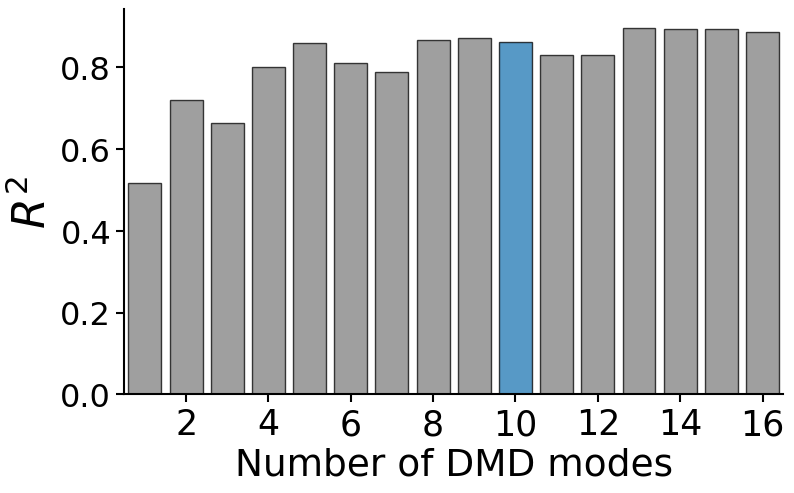

In [28]:
import seaborn as sns

savefig = False

fig,ax = plt.subplots(1,1,figsize=(8.5,5))
color_list = ['tab:gray']*16; color_list[9] = 'tab:blue'
g = sns.barplot(r_list,np.abs(cd_list),ax=ax,palette=color_list,saturation=1,edgecolor='k',alpha=0.75)
# g.legend_.remove();
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
ax.set_xticks(list(range(1,17,2)));
ax.set_xlabel('Number of DMD modes',fontsize=27); ax.set_ylabel(r'$R^2$',fontsize=32)
if savefig: 
    plt.savefig(figDir + 'fig2/R2_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

/tmp/ipykernel_79935/3845042794.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


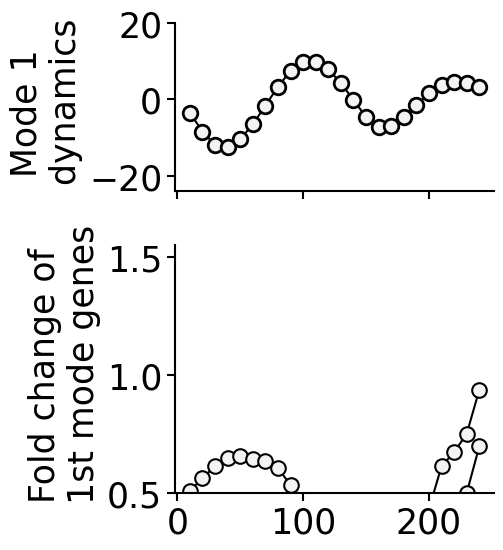

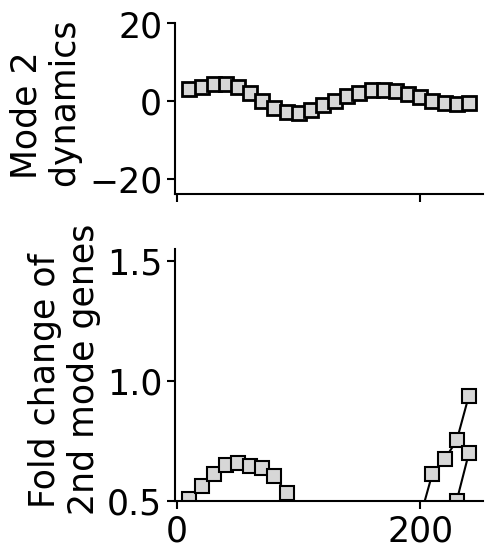

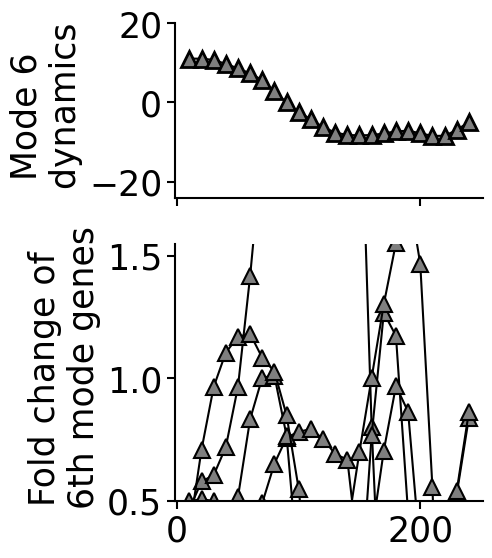

In [29]:
##### cluster genes based on modes

data_fc=data_f

savefig = False

Phi_mag = np.abs(Phi)

kmax = 20 # get most impacted genes
kmax_inds = []
for ii in range(Phi_mag.shape[1]):
    kmax_inds.append(Phi_mag[:,ii].argsort()[-kmax:])

heights = [0.85,1.25]
my_figsize = (4.8,6)

cmap = matplotlib.cm.get_cmap('Greys')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.1,0.9,6)]

fig1,axs1 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[0]*b_r0[0])
axs1[0].plot(corr_tspan,savgol(scaled_mode,3,1),'o-',ms=10.5,mec='k',mew=2,c='k',mfc=grad_colors[0],lw=1.5)
for ii in range(6,16): # only plot the top 10 
    axs1[1].plot(corr_tspan,savgol(data_fc[kmax_inds[0][ii],:,1],3,1),'o-',c='k',mfc=grad_colors[0],
           ms=10.5,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs1.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs1[0].set_ylim(-24,20)
axs1[1].set_ylim(0.5,1.55)
axs1[0].set_ylabel('Mode 1 \n dynamics',fontsize=25) 
axs1[1].set_ylabel('Fold change of \n 1st mode genes',fontsize=25) 

fig2,axs2 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[1]*b_r1[1])
axs2[0].plot(corr_tspan,savgol(scaled_mode,3,1),'s-',ms=10.5,mec='k',mew=2,c='k',mfc=grad_colors[1],lw=1.5)
for ii in range(6,16): # only plot the top 10 
    axs2[1].plot(corr_tspan,savgol(data_fc[kmax_inds[1][ii],:,1],3,1),'s-',c='k',mfc=grad_colors[1],
           ms=10.5,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs2.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs2[0].set_ylim(-24,20)
axs2[1].set_ylim(0.5,1.55)
axs2[0].set_ylabel('Mode 2 \n dynamics',fontsize=25) 
axs2[1].set_ylabel('Fold change of \n 2nd mode genes',fontsize=25) 
    
fig3,axs3 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[5]*b_r1[5])
axs3[0].plot(corr_tspan,savgol(scaled_mode,3,1),'^-',ms=12,mec='k',mew=2,c='k',mfc=grad_colors[3],lw=1.5)
for ii in range(10,kmax): # only plot the top 10 
    axs3[1].plot(corr_tspan,savgol(data_fc[kmax_inds[3][ii],:,1],3,1),'^-',c='k',mfc=grad_colors[3],
           ms=12,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs3.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs3[0].set_ylim(-24,20)
axs3[1].set_ylim(0.5,1.55)
axs3[0].set_ylabel('Mode 6 \n dynamics',fontsize=25) 
axs3[1].set_ylabel('Fold change of \n 6th mode genes',fontsize=25) 

if savefig: 
    fig1.savefig(figDir + 'fig2/mode1_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig2.savefig(figDir + 'fig2/mode2_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig3.savefig(figDir + 'fig2/mode6_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

r2_score for n-step prediction: 8.630e-01


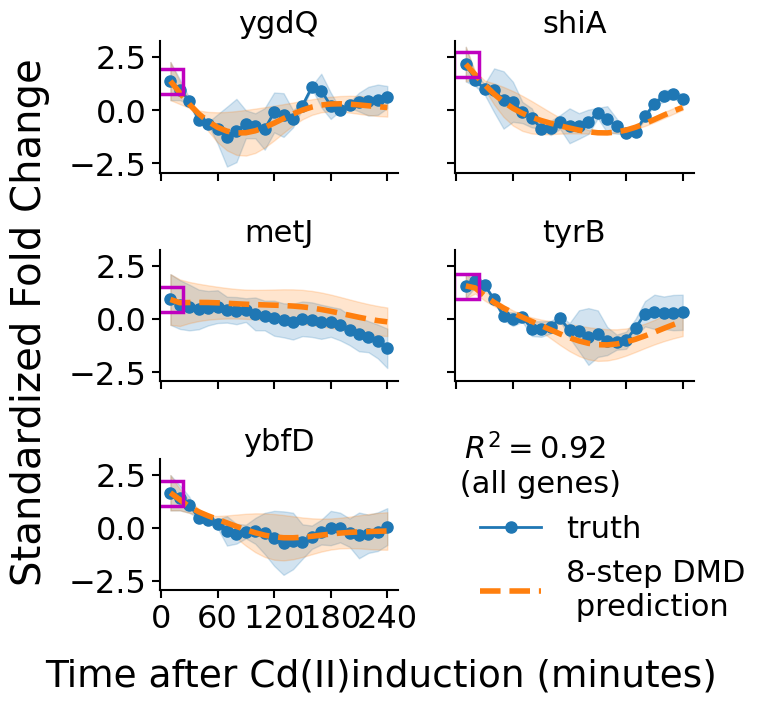

In [30]:
##### visualize the predictions for several randomly selected genes
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

X_pred, cd_ = n_step_prediction(A,data_fc_norm,data_fc_norm.shape[1],data_fc_norm.shape[2])
Xpred = X_pred.reshape(len(A),data_fc_norm.shape[1],data_fc_norm.shape[2],order='F')

fig,axs = plt.subplots(3,2,figsize=(7,7),sharex=True,sharey=True)
fig.delaxes(axs[-1,-1])
pinds = [3,100,583,164,309] # plot these genes (selected randomly)
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(pinds):
        pind = pinds[ii]
        act_mean = np.mean(data_fc_norm[pind],axis=1)
        pred_mean = np.mean(Xpred[pind],axis=1)
        act_std = np.std(data_fc_norm[pind],axis=1)
        pred_std = np.std(Xpred[pind],axis=1)
        ax.plot(corr_tspan,act_mean,'o-',ms=8,lw=2,c='tab:blue')
        ax.plot(corr_tspan,pred_mean,'--',lw=4,c='tab:orange')
        ax.fill_between(corr_tspan,act_mean-act_std,act_mean+act_std,color='tab:blue',alpha=0.2)
        ax.fill_between(corr_tspan,pred_mean-pred_std,pred_mean+pred_std,color='tab:orange',alpha=0.2)
        # also plot a marker indicating that the IC is given as input to the model
        ax.plot(10,act_mean[0],'s',ms=18,c='m',mfc='None',mew=2.5)
        ax.set_xticks(range(0,250,60))
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
        if df.columns[pind] != 'N/A':
            ax.set_title(df.columns[pind],fontsize=22)
        else: 
            ax.set_title(df.columns[pind],fontsize=22)

fig.legend(['truth','8-step DMD \n prediction'],frameon=False,loc=(0.61,0.1),fontsize=22);
fig.text(0.5, -0.02, 'Time after '+input_label+'induction (minutes)', ha='center',fontsize=27);
fig.text(-0.03, 0.5, 'Standardized Fold Change', va='center', rotation='vertical',fontsize=29);
fig.text(0.72,0.256,r'$R^2=0.92$' '\n (all genes)',ha='center',fontsize=22)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir + 'fig2/error_timeseries.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

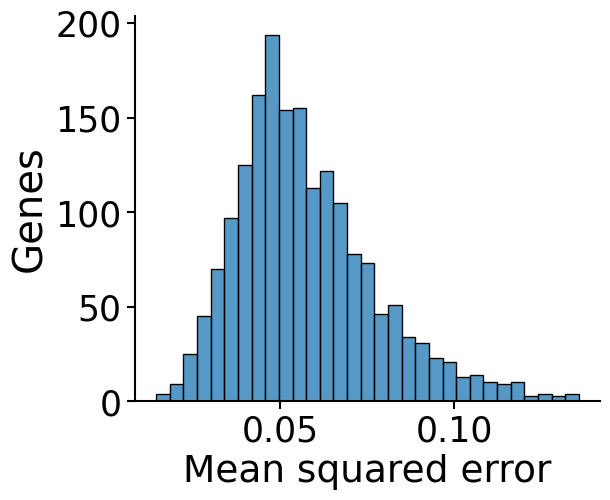

In [31]:
#### visualize the histogram of the per gene residuals

savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

mse_per_gene = (np.linalg.norm(np.linalg.norm(Xpred - data_fc_norm,axis=2),axis=1) 
                / (Xpred.shape[1]*Xpred.shape[2]))

fig, ax = plt.subplots(figsize=(6,5))
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
sns.histplot(mse_per_gene)
plt.xlabel('Mean squared error',fontsize=27)
plt.ylabel('Genes',fontsize=29)
if savefig: 
    plt.savefig(figDir + 'fig2/mse_histogram_dmd.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [32]:
from sensor_placement import finite_horizon_obs_gramian

Xo1, Xo1_proj = finite_horizon_obs_gramian(A,V[:,0:1].T,10)
print('Xo1 volume:', np.linalg.det(Xo1_proj))
Xo2, Xo2_proj = finite_horizon_obs_gramian(A,V[:,1:2].T,10)
print('Xo2 volume:', np.linalg.det(Xo2_proj))
Xo3, Xo3_proj = finite_horizon_obs_gramian(A,V[:,2:3].T,10)
print('Xo3 volume:', np.linalg.det(Xo3_proj))

Xo1 volume: 2.280262878474432
Xo2 volume: 0.36071080382169934
Xo3 volume: 3.010118167084938


In [33]:
Xo, Xo_proj = finite_horizon_obs_gramian(A,V[:,0:3].T,10)
print('Xo volume:', np.linalg.det(Xo_proj))

Xo volume: 222.35626859898719


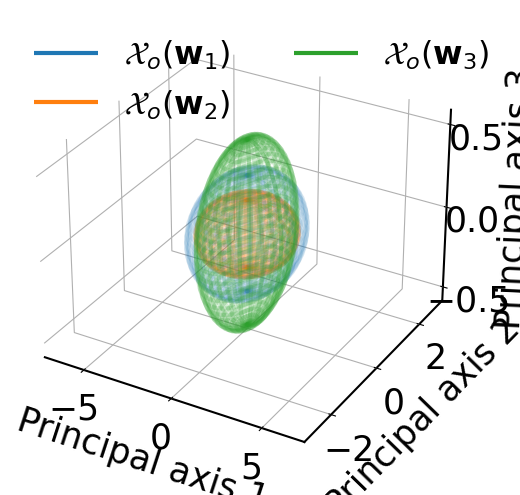

In [34]:
# plot gramian ellipsoids
from plot_ellipsoid import get_ellipsoid

savefig = False

X1,Y1,Z1 = get_ellipsoid(Xo1_proj)
X2,Y2,Z2 = get_ellipsoid(Xo2_proj)
X3,Y3,Z3 = get_ellipsoid(Xo3_proj)

fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw=dict(projection='3d'))

ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:blue',label=r'$\mathcal{X}_o(\mathbf{w}_1)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:orange',label=r'$\mathcal{X}_o(\mathbf{w}_2)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:green',label=r'$\mathcal{X}_o(\mathbf{w}_3)$')
ax.plot_wireframe(X1,Y1,Z1, color='tab:blue', alpha=0.1)
ax.plot_wireframe(X2,Y2,Z2, color='tab:orange', alpha=0.15)
ax.plot_wireframe(X3,Y3,Z3, color='tab:green', alpha=0.2)
ax.set_xlabel('Principal axis 1',labelpad=10)
ax.set_ylabel('Principal axis 2',labelpad=10)
ax.set_zlabel('Principal axis 3',labelpad=10)
# get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_ylim(-3,3)
ax.set_xlim(-7,7)
# ax.set_zlim(-2,2)
plt.legend(frameon=False,ncol=2,bbox_to_anchor=(1.1,1.00),fontsize=23)
if savefig: 
    plt.savefig(figDir + 'fig3/gramian_ellipsoids.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

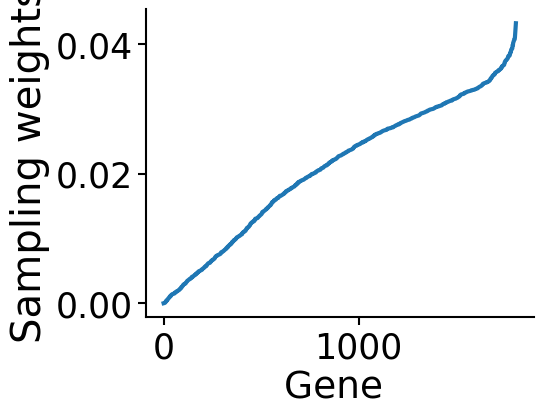

In [35]:
# sampling weights unscaled
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.plot(np.sort(np.abs(W[0])))

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Gene ',fontsize=27);
ax.set_ylabel('Sampling weights',fontsize=29);

if savefig:
    plt.savefig(figDir + 'supplementalFigs/Sampling_weights.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

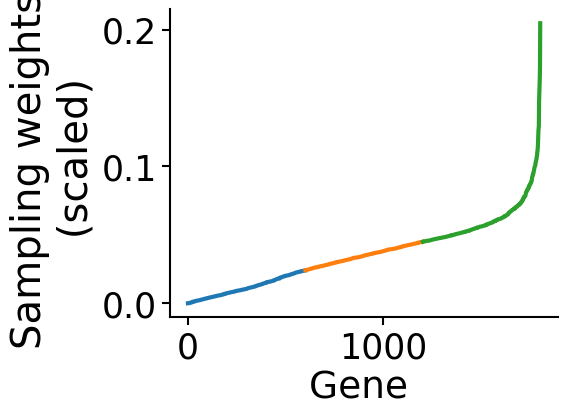

In [36]:
# visualize the weights in gene sampling vector and form three groups
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

# W_scaled = (np.abs(W[0]) - np.abs(W[0]).min())/(np.abs(W[0]).max() - np.abs(W[0]).min())

# # get the indices of the genes with the ngenes/3 largest sampling weights
nInds = int(len(data_fc_norm)/3)
# high_inds = list(np.abs(W[0]).argsort()[-nInds:][::-1])
# low_inds = list(np.abs(W[0]).argsort()[:nInds])
# mid_inds = list(set(list(range(len(W[0])))) - set(high_inds).union(set(low_inds)))

fig,ax = plt.subplots(1,1,figsize=(5,4))
# ax.plot(range(nInds),np.abs(W[0][low_inds]),mew=0.3,ms=10,c='tab:blue',alpha=1)
# ax.plot(range(nInds,2*nInds),np.sort(np.abs(W[0][mid_inds])),mew=0.3,ms=10,c='tab:orange',alpha=1)
# ax.plot(range(2*nInds,3*nInds),np.abs(W[0][high_inds])[::-1],mew=0.3,ms=10,c='tab:green',alpha=1)
ax.plot(range(nInds),np.sort(np.abs(Wn))[0:nInds])
ax.plot(range(nInds,2*nInds),np.sort(np.abs(Wn))[nInds:2*nInds])
ax.plot(range(2*nInds,3*nInds),np.sort(np.abs(Wn))[2*nInds:3*nInds])
# ax.plot([0,len(Ws)],[np.abs(Wn).min(),np.abs(Wn).max()],'--',c='k',lw=1.5,zorder=0)

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Gene ',fontsize=27);
# ax.set_ylabel('Sampling weights',fontsize=29);
ax.set_ylabel('Sampling weights \n (scaled)',fontsize=29);

if savefig:
    plt.savefig(figDir + 'fig3/Sampling_weights.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

In [37]:
# get the indices of the genes with the ngenes/3 largest sampling weights

from sensor_placement import reconstruct_x0
from random import choices

nInds = int(len(data_fc_norm)/3)
high_inds = list(np.abs(Wn).argsort()[-nInds:][::-1])
low_inds = list(np.abs(Wn).argsort()[:nInds])
mid_inds = list(set(list(range(len(Wn)))) - set(high_inds).union(set(low_inds)))

def mc_reconstruction(p=50,nT=1,N=100):
    '''
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_high = []
    for ii in range(N):
        inds = choices(high_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_high.append(reconstruct_x0(data_fc_norm,nT,A,C))

    r2_mid = []
    for ii in range(N):
        inds = choices(mid_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_mid.append(reconstruct_x0(data_fc_norm,nT,A,C))

    r2_low = []
    for ii in range(N):
        inds = choices(low_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)        
        C[:,set_to_zero] = 0.0
        r2_low.append(reconstruct_x0(data_fc_norm,nT,A,C))
        
    return r2_low, r2_mid, r2_high

# takes several minutes to run
doRun = False
doDump = False
if doRun:
    r2_low_nTlow, r2_mid_nTlow, r2_high_nTlow = mc_reconstruction(p=50,nT=2,N=100) # p=nInds//2
    r2_low, r2_mid, r2_high = mc_reconstruction(p=50,nT=8,N=100) # p=nInds//2 (50)     
    mc_recon_list = [r2_low_nTlow, r2_mid_nTlow, r2_high_nTlow, r2_low, r2_mid, r2_high]

if doDump: 
    pickle.dump(mc_recon_list,open('data/mc_reconstruction.pkl','wb'))    
    
if not doRun:    
    mc_recon_list = pickle.load(open('data/mc_reconstruction.pkl','rb'))

In [38]:
def mc_reconstruction_single(p=50,nT=1,N=100):
    '''
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''

    r2_high = []
    for ii in range(N):
        inds = choices(high_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_high.append(reconstruct_x0(data_fc_norm,nT,A,C))
    
    return r2_high


doRun = False
doDump = False
if doRun:
    times = [1,2,3,4,5,6,7,8,9,10]
    r2_times_high = []
    for this_t in times: 
        r2_high = mc_reconstruction_single(p=50,nT=this_t,N=50)
        r2_times_high.append( r2_high )

if doDump:
    pickle.dump(r2_times_high, open('data/mc_reconstruction_highs.pkl','wb'))
    
if not doRun:
    r2_times_high = pickle.load(open('data/mc_reconstruction_highs.pkl','rb'))

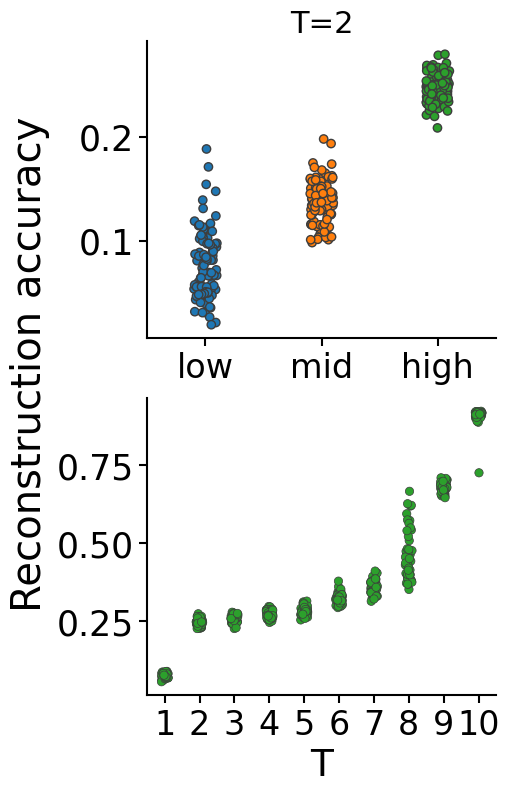

In [39]:
savefig = False

times = [1,2,3,4,5,6,7,8,9,10]


fig,ax=plt.subplots(2,1,figsize=(4.5,8.5),sharex=False,sharey=False) # gridspec_kw={'height_ratios': [1, 1.5]}
sns.stripplot(data=pd.DataFrame(mc_recon_list[0:3]).T,s=6,linewidth=1,ax=ax[0])
sns.stripplot(data=pd.DataFrame(r2_times_high).T,color='tab:green',s=6,linewidth=0.5,ax=ax[1])

fig.text(-0.18, 0.5, 'Reconstruction accuracy', va='center', rotation='vertical',fontsize=29)
ax[0].set_title('T=2',fontsize=22)
for thisax in ax.reshape(-1):
    thisax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    thisax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax[0].set_xticklabels(['low','mid','high'],fontsize=24)
ax[1].set_xticklabels(times,fontsize=24)
ax[1].set_xlabel('T',fontsize=27)
if savefig:
    plt.savefig(figDir + 'fig3/monte_carlo_reconstruction.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

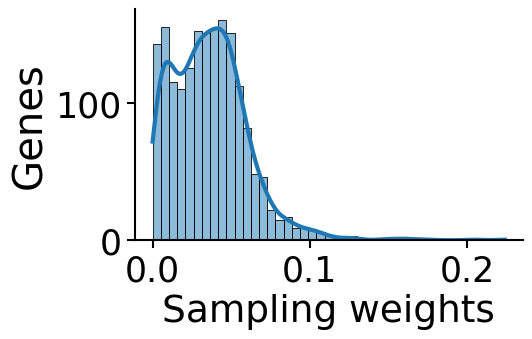

In [40]:
# histogram of the weights in C
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(5,3))
# ax.hist((np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/(np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),
#         rwidth=0.825,align='right',linewidth=1.5,edgecolor='k',alpha=0.9)
# sns.histplot((np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/(np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),kde=True,ax=ax)
sns.histplot(np.abs(Wn),kde=True)
# plt.plot([0.05,0.05],[0,100],c='r')

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Sampling weights',fontsize=27);
ax.set_ylabel('Genes',fontsize=29);
if savefig:
    plt.savefig(figDir + 'fig3/sampling_weights_hist.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

/tmp/ipykernel_79935/2499498228.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('YlGn_r')


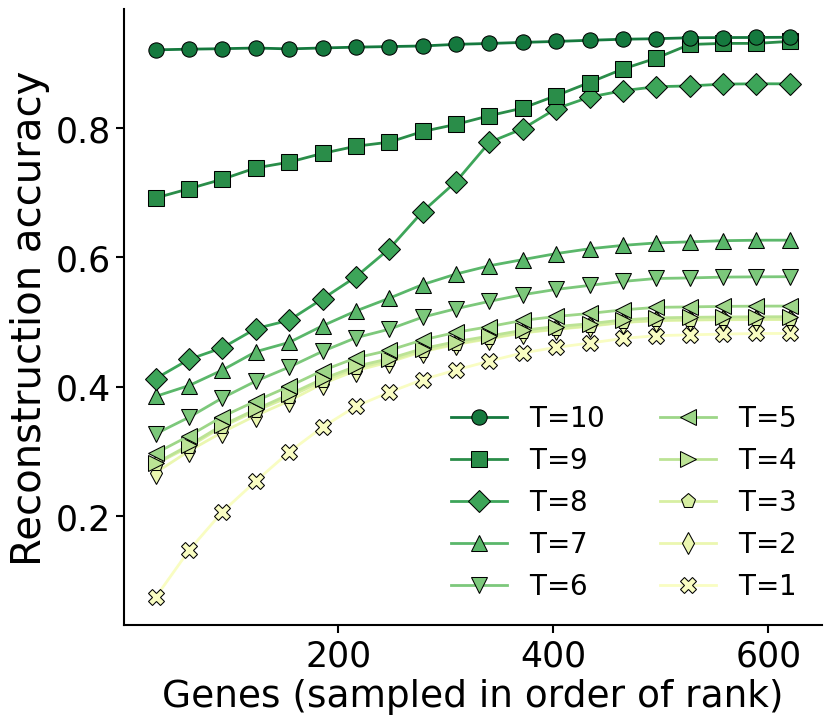

In [41]:
# state estimation error
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
plt.rc('lines',linewidth=4);
plt.rc('lines',markersize=16);

cmap = matplotlib.cm.get_cmap('YlGn_r')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.2,0.9,10)]
fig,ax = plt.subplots(1,1,figsize=(9,8));
mec = 'k'
mew = 0.75
alpha = 1
xrange = np.linspace(samplingFreq,620,len(rho_list[0]))
my_labels = [r'T=$10$',r'T=$9$',r'T=$8$',r'T=$7$',r'T=$6$',r'T=$5$',r'T=$4$',r'T=$3$',r'T=$2$',r'T=$1$']
my_markers = ['o','s','D','^','v','<','>','p','d','X']
for ii in range(len(rho_list)):
    ax.plot(xrange,rho_list[ii],my_markers[ii]+'-',mfc=grad_colors[ii]+[alpha],c=grad_colors[ii]+[alpha],
            mec=mec,mew=mew,ms=11,lw=2,label=my_labels[ii],zorder=10-ii)
# ax.set_xticks([1,20,40,60,80])
ax.set_xlabel('Genes (sampled in order of rank)',fontsize=27);
ax.set_ylabel('Reconstruction accuracy',fontsize=29);
# ax.set_ylabel(r'$\mathregular{\rho(\mathbf{z}_0,\mathcal{O}_T^{\dagger} \mathbf{y})}$',fontsize=26);
ax.legend(frameon=False,ncol=2,fontsize=20)
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
if savefig: 
    plt.savefig(figDir + 'fig3/state_estimation_error.pdf',dpi=300,bbox_inches='tight',transparent=True)    
plt.show();

In [42]:
def mc_reconstruction_top_n(n=15,p=15,nT=2,N=100):
    '''
    n: top n% of genes only
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_list = []
    corr_list = []
    keep_inds = list(np.argsort(np.abs(Wn))[-int(len(Wn)*(n)/100):])
    set_to_zero = list( set(list(range(len(Wn)))) - set(keep_inds) )
    C = deepcopy(Wn)
    C = np.expand_dims(C,axis=0)
    C[:,set_to_zero] = 0.0
    for ii in range(N):
        Cn = deepcopy(C)
        inds = choices(keep_inds,k=p)  
        set_to_zero_n = list(set(keep_inds) - set(inds))
        Cn[:,set_to_zero_n] = 0.0
        r2_list.append(reconstruct_x0(data_fc_norm,nT,A,Cn))
        corr_list.append( 
            np.linalg.norm(np.ones((p,p))-
                           np.abs(np.corrcoef(data_fc_norm[inds].reshape(p,-1,order='F'))),ord='fro') )
    return r2_list, corr_list

doRun = False
doDump = False
if doRun:
    r2_top_n, corr_top_n = mc_reconstruction_top_n(n=15,p=15,nT=nT,N=100)

if doDump:
    pickle.dump([r2_top_n,corr_top_n],open('data/top_n_list.pkl','wb'))

if not doRun:
    r2_top_n, corr_top_n = pickle.load(open('data/top_n_list.pkl','rb'))

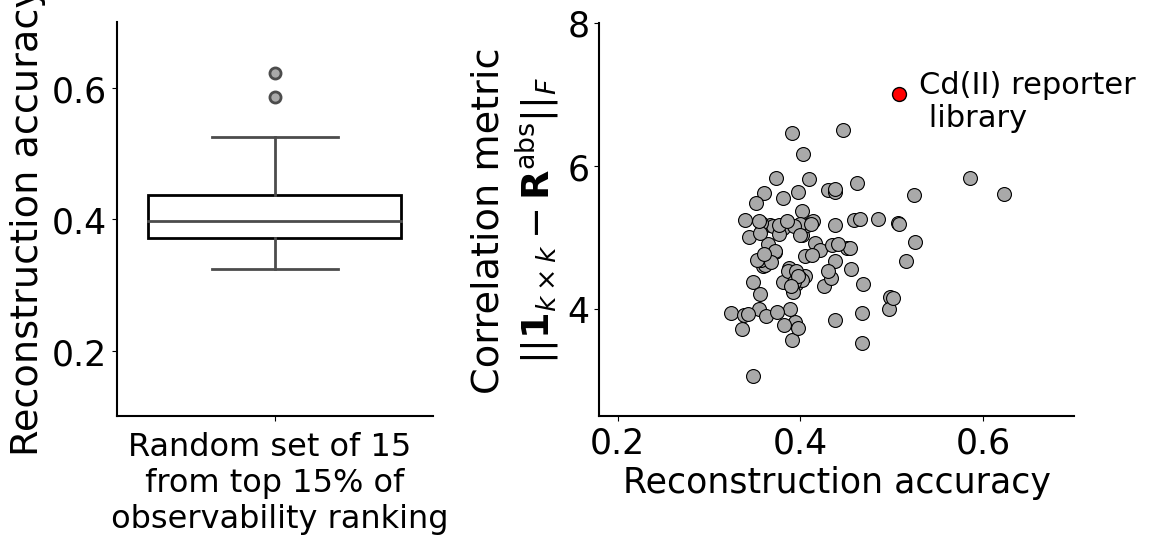

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios':[0.4,0.6]})
sns.boxplot(data=pd.DataFrame(r2_top_n),color='tab:gray',linewidth=2,ax=ax[0],
            flierprops={"marker": "o","mfc":'darkgray',"mew":2,"ms":8},
            boxprops={'facecolor':'none', 'edgecolor':'k'})
ax[0].set_xticklabels([''],fontsize=24)
ax[0].set_xlabel('Random set of 15 \n from top 15% of \n observability ranking',fontsize=23)
ax[0].set_ylabel('Reconstruction accuracy',fontsize=27.5)
sns.scatterplot(x=r2_top_n,y=corr_top_n,ax=ax[1],color='darkgray',edgecolor='k',s=100)
# chosen gene set 
plt.plot(0.5080958828078517,7.0,'o',c='red',mec='k',ms=10)
ax[1].text(0.53,6.55, input_label+' reporter \n library',fontsize=22)
ax[1].set_xlabel('Reconstruction accuracy')
ax[1].set_ylabel('Correlation metric\n' + 
                 r'$|| \mathbf{1}_{k\times k} - \mathbf{R}^{\mathrm{abs}}||_F $',fontsize=27.5)
ax[0].set_ylim(0.1,0.7)
ax[1].set_ylim(2.5,8)
ax[1].set_xlim(0.18,0.7)
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/mc_analysis_top.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [44]:
def mc_reconstruction_random(n=300,p=15,nT=2,N=100):
    '''
    n: number of genes to subsample from
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_list = []
    corr_list = []
    rank_list = [] # average rank of gene set
    inds1 = choices(list(range(len(Wn))),k=n)
    for ii in range(N):
        inds2 = choices(inds1,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds2))
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_list.append(reconstruct_x0(data_fc_norm,nT,A,C))
        corr_list.append( 
            np.linalg.norm(np.ones((p,p))-
                           np.abs(np.corrcoef(data_fc_norm[inds2].reshape(p,-1,order='F'))),ord='fro') )
        rank_list.append( np.mean([list(np.argsort(np.abs(Wn))).index(x) for x in inds2]))
    return r2_list, corr_list, rank_list

doRun = False
doDump = False
if doRun:
    r2_random, corr_random, rank_random = mc_reconstruction_random(n=len(Wn)//2,p=11,nT=6,N=100)
    
if doDump: 
    pickle.dump([r2_random,corr_random,rank_random],open('data/random_list.pkl','wb'))

if not doRun:
    r2_random, corr_random, rank_random = pickle.load(open('data/random_list.pkl','rb'))

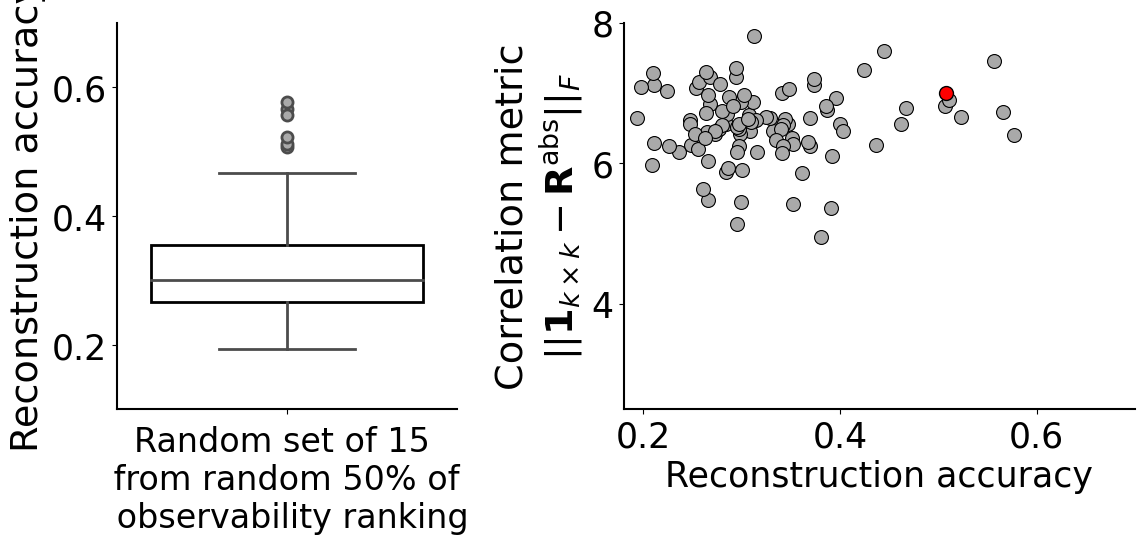

In [45]:
fig,ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios':[0.4,0.6]})
sns.boxplot(data=pd.DataFrame(r2_random),color='tab:gray',linewidth=2,ax=ax[0],
            flierprops={"marker": "o","mfc":'darkgray',"mew":2,"ms":8},
            boxprops={'facecolor':'none', 'edgecolor':'k'})
ax[0].set_xticklabels([''],fontsize=24)
ax[0].set_xlabel('Random set of 15 \n from random 50% of \n observability ranking',fontsize=24)
ax[0].set_ylabel('Reconstruction accuracy',fontsize=27.5)
sns.scatterplot(x=r2_random,y=corr_random,ax=ax[1],edgecolor='k',color='darkgray',s=100)
# chosen gene set 
plt.plot(0.5080958828078517,7.0,'o',c='red',mec='k',ms=10)
# ax[1].text(0.53,6.55,'malathion reporter \n library',fontsize=22)
ax[1].set_xlabel('Reconstruction accuracy'); 
ax[1].set_ylabel('Correlation metric\n' + 
                 r'$|| \mathbf{1}_{k\times k} - \mathbf{R}^{\mathrm{abs}}||_F $',fontsize=27.5)
ax[0].set_ylim(0.1,0.7)
ax[1].set_ylim(2.5,8)
ax[1].set_xlim(0.18,0.7)
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/mc_analysis_random.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [47]:
# reconstruction x0 using top 15 genes in Wn
set_to_zero = list(set(list(range(len(Wn)))) - set(list(np.argsort(np.abs(Wn))[-15:])))
C = deepcopy(Wn)
C[set_to_zero] = 0.0
C = C.reshape(-1,len(C))
r2 = reconstruct_x0(data_fc_norm,nT,A,C)
print(r2)

0.8897793919964034


3.0292965234369515


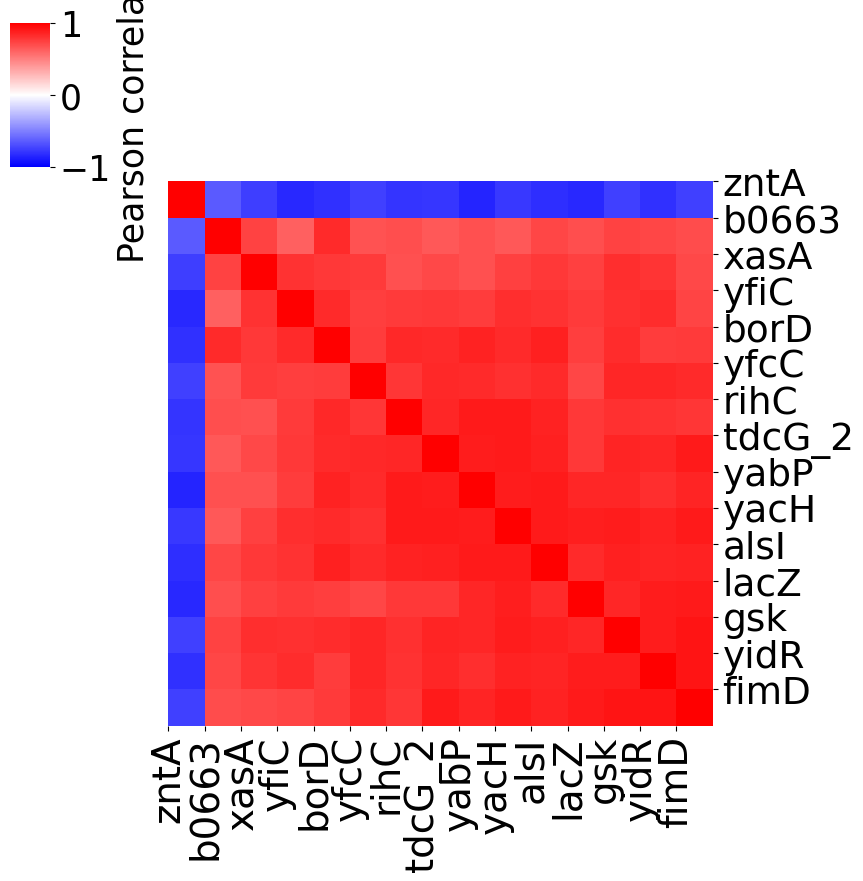

In [48]:
# correlations among chosen sensor genes

cg = sns.clustermap(np.corrcoef(data_fc_norm[list(df_up_new.tag_ind)].reshape(15,-1,order='F')),
           vmax=1,vmin=-1,cmap='bwr',cbar_kws={'label':'Pearson correlation'},figsize=(8,8),)
reordered_inds = cg.dendrogram_col.reordered_ind
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_heatmap.set_xticks(range(len(df_up_new)))
cg.ax_heatmap.set_xticklabels([''.join(list(df_up_new.gene)[x].split('\n ')) for x in reordered_inds],
                             rotation=90,fontsize=28)
cg.ax_heatmap.set_yticks(range(len(df_up_new)))
cg.ax_heatmap.set_yticklabels([''.join(list(df_up_new.gene)[x].split('\n ')) for x in reordered_inds],
                             rotation=0,fontsize=27)
# cg.fig.savefig(figDir + 'supplementalFigs/library_correlations.pdf',dpi=300,transparent=True,bbox_inches='tight')

print( np.linalg.norm( np.ones((15,15)) - np.abs(np.corrcoef(data_fc_norm[list(df_up_new.tag_ind)].reshape(15,-1,order='F'))), ord='fro' ) )